In [1]:
!pip install -q imbalanced-learn shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE

import joblib
import shap


In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data-bank.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


#**3. Overview & EDA dasar**
untuk melihat ukuran data, tipe, dan imbalance kelas.

(6819, 96)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-

None

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


Missing per column:
 Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


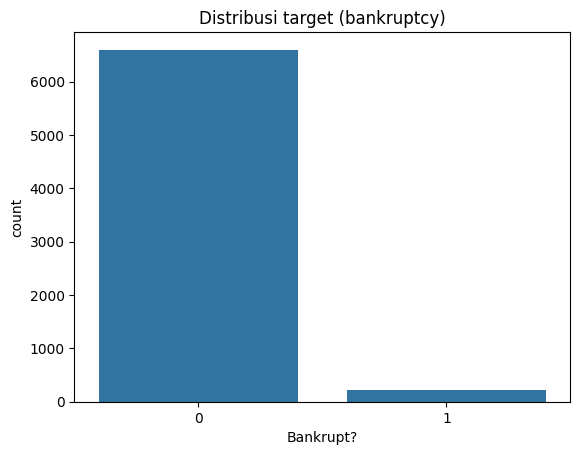

In [8]:
print(df.shape)
display(df.info())
display(df.describe())

print("Missing per column:\n", df.isnull().sum())

target = 'Bankrupt?'
print(df[target].value_counts())
sns.countplot(x=target, data=df)
plt.title('Distribusi target (bankruptcy)')
plt.show()

#**4. Korelasi & Visualisasi Fitur**
Menampilkan hubungan antar fitur numerik dan bagaimana distribusi setiap fitur terhadap status kebangkrutan (Bankrupt? = 0 atau 1).

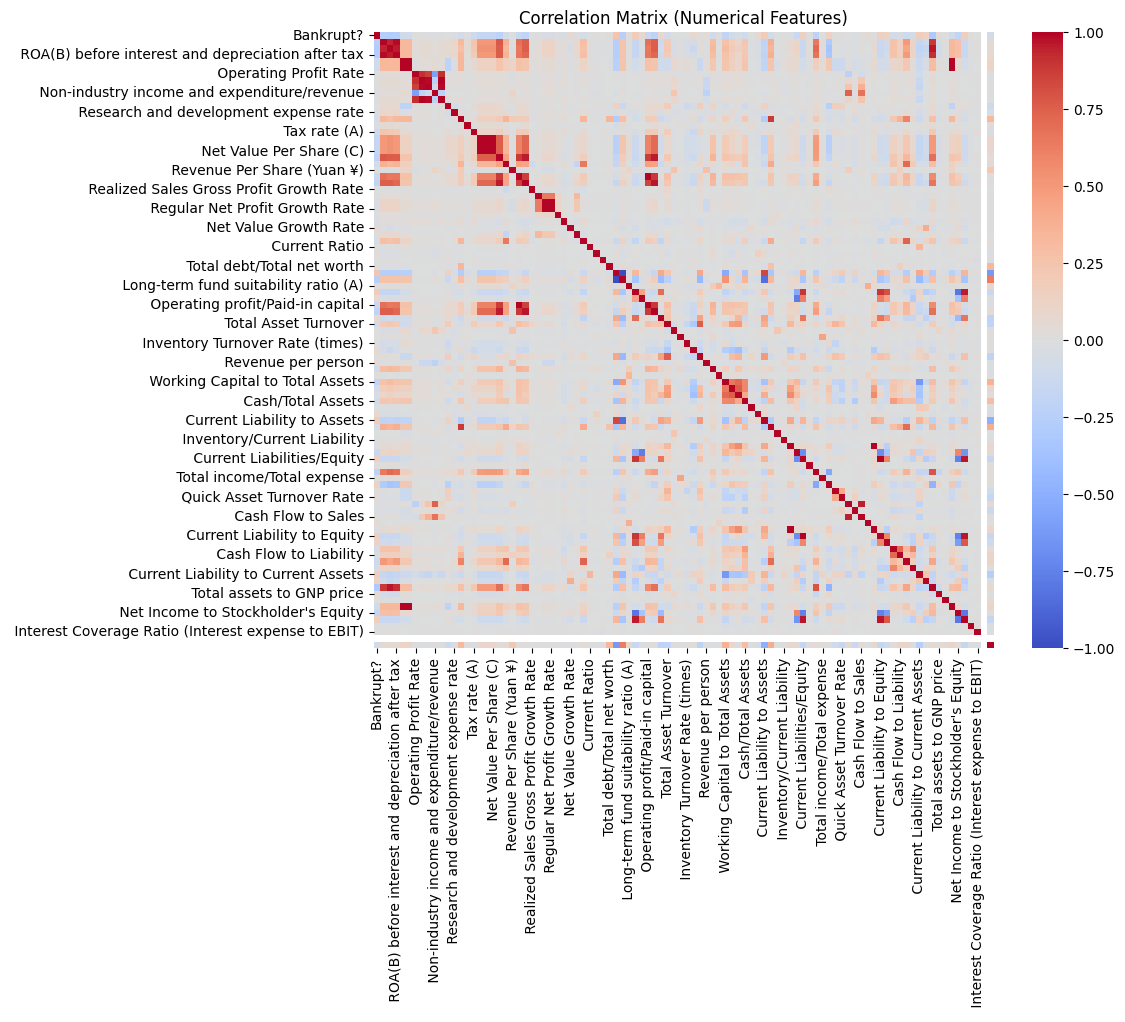

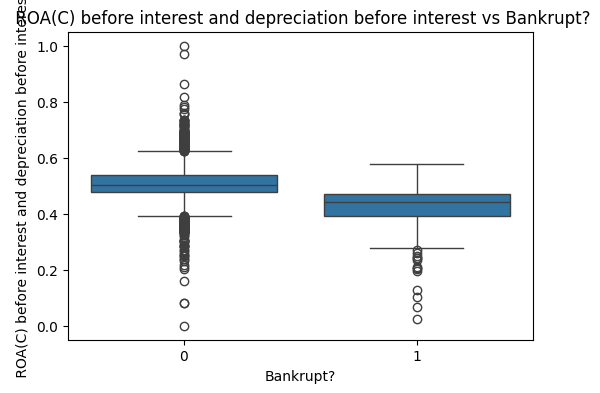

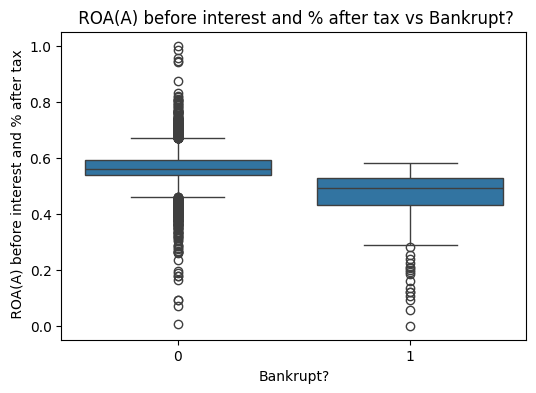

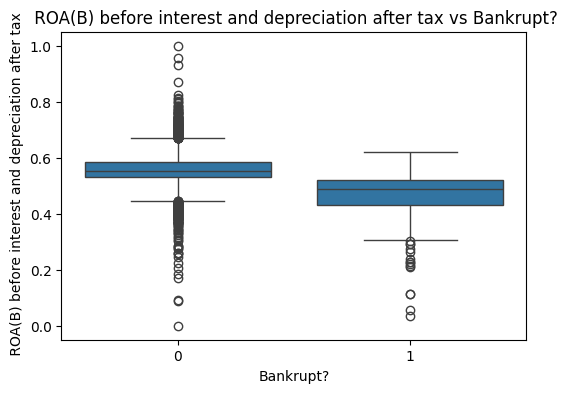

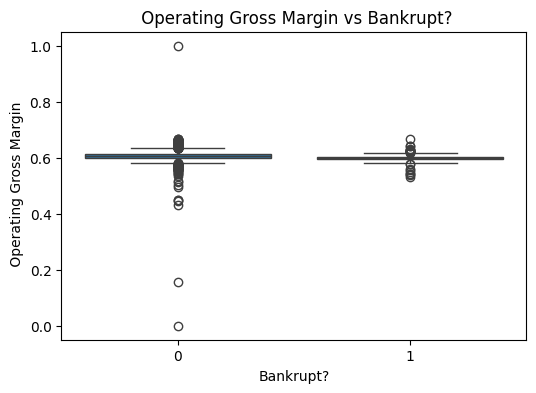

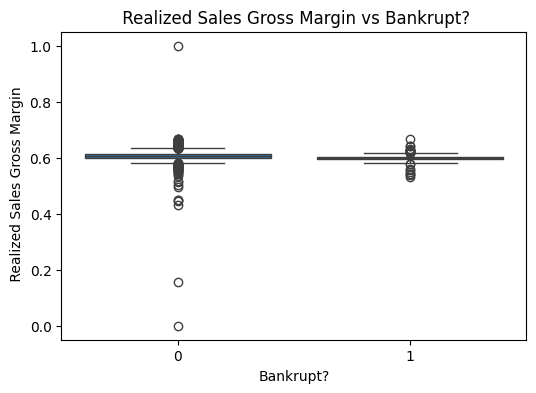

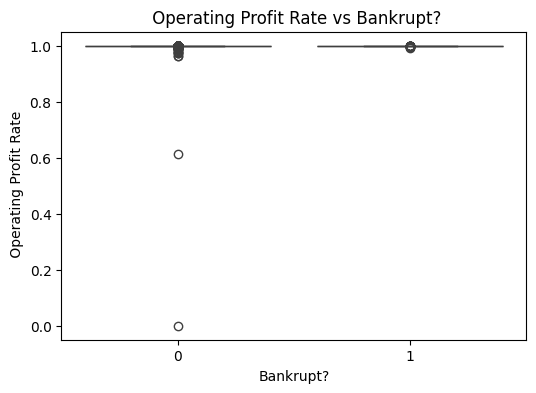

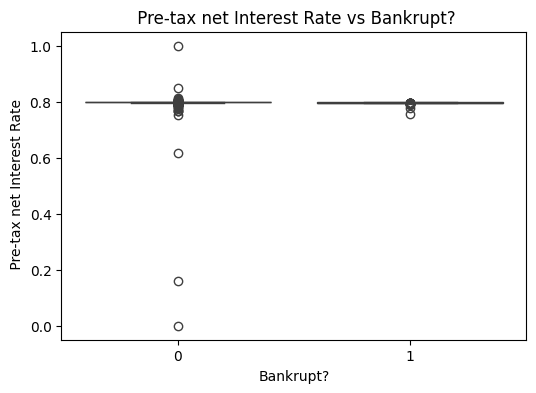

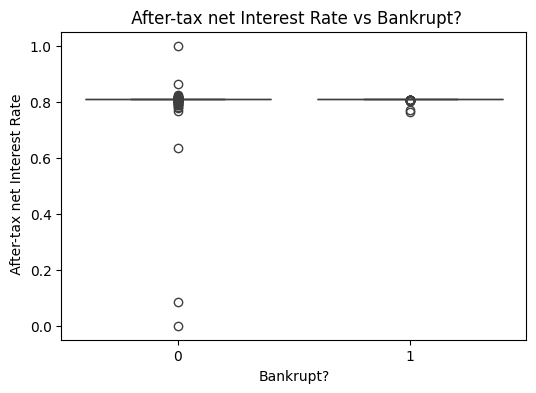

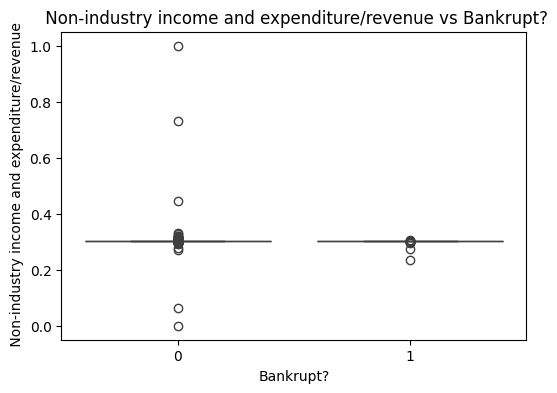

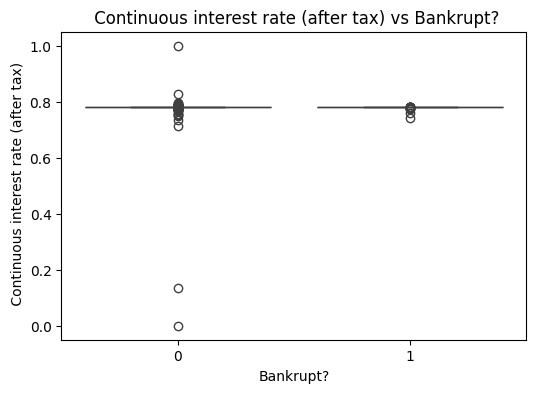

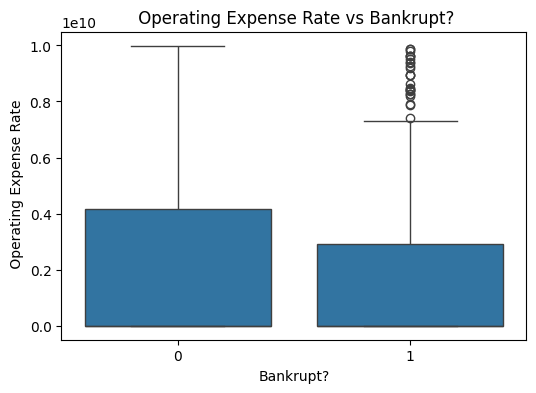

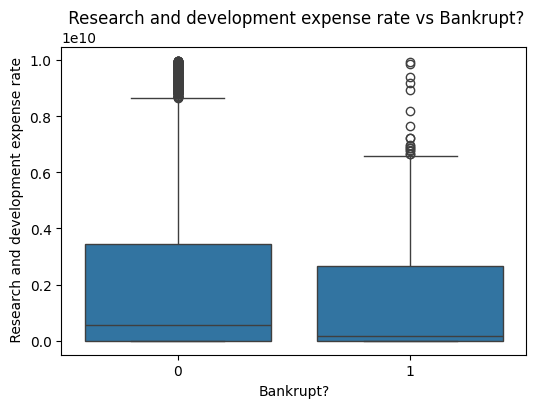

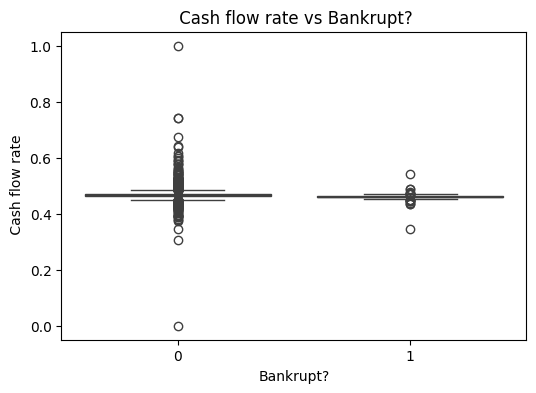

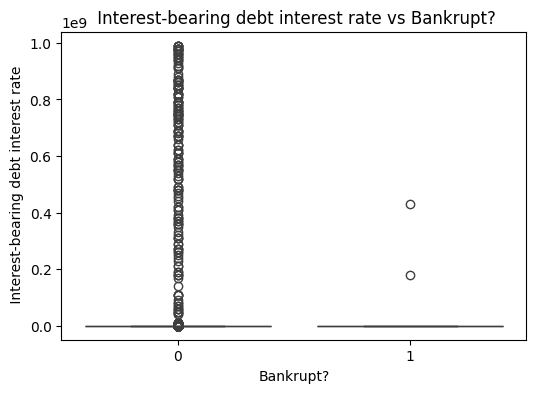

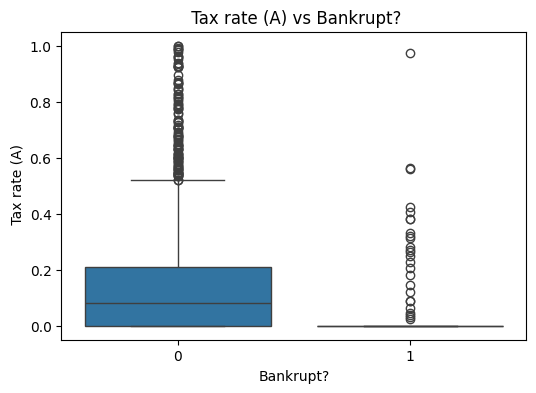

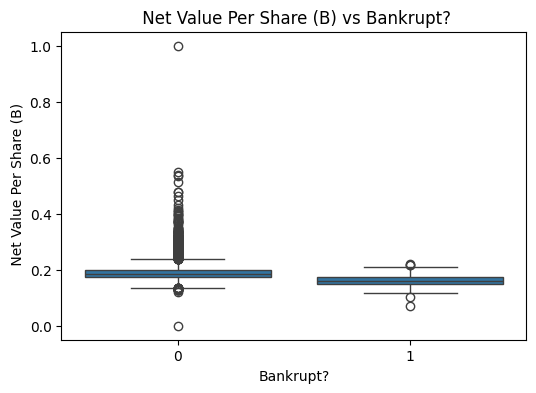

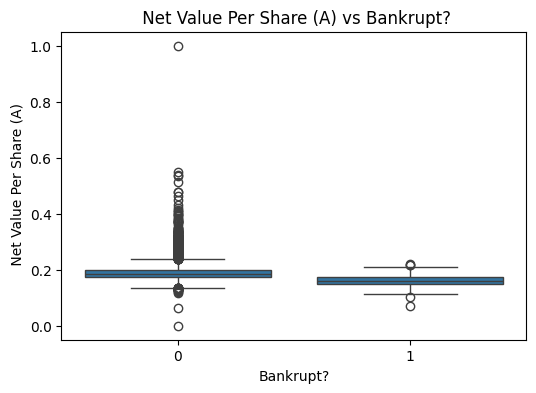

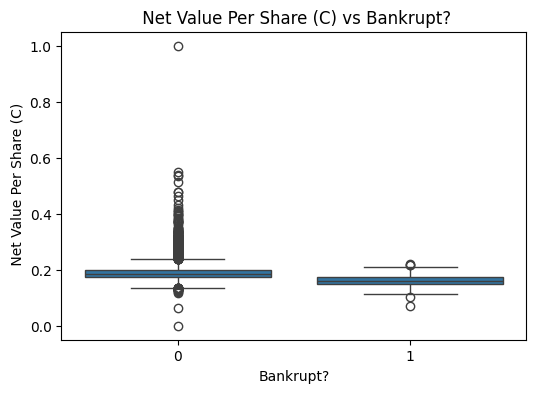

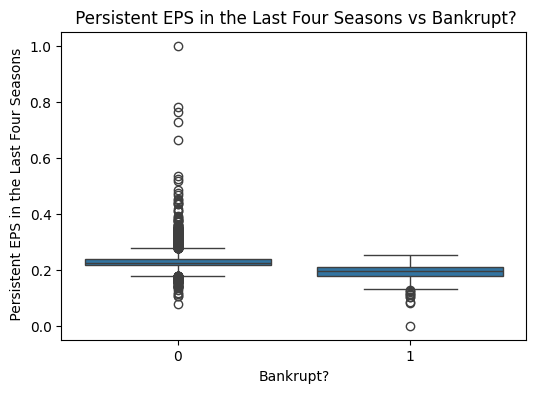

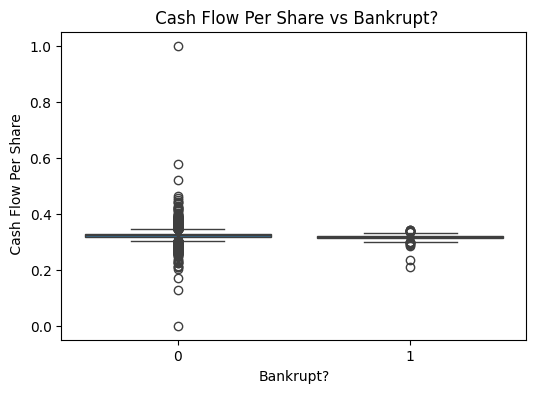

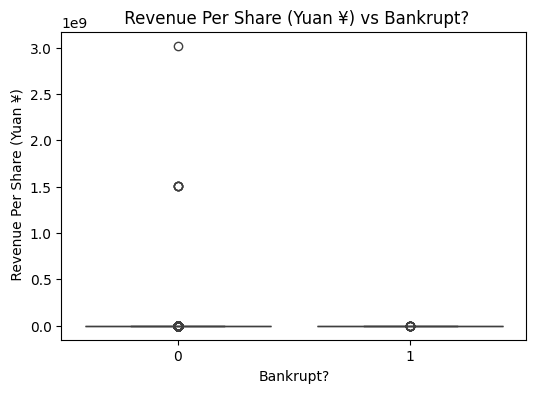

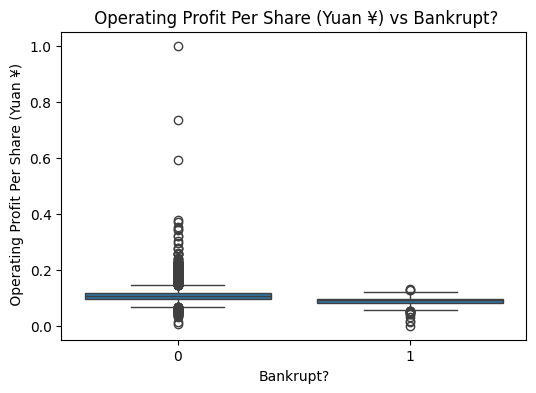

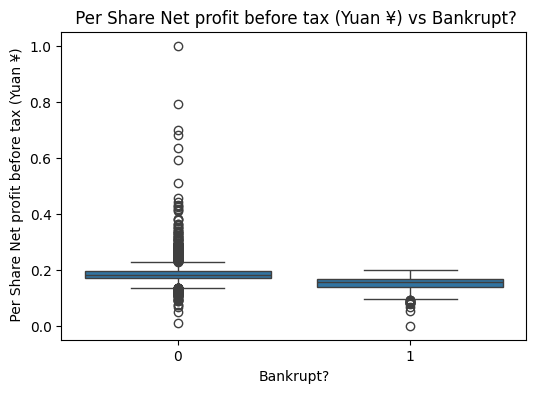

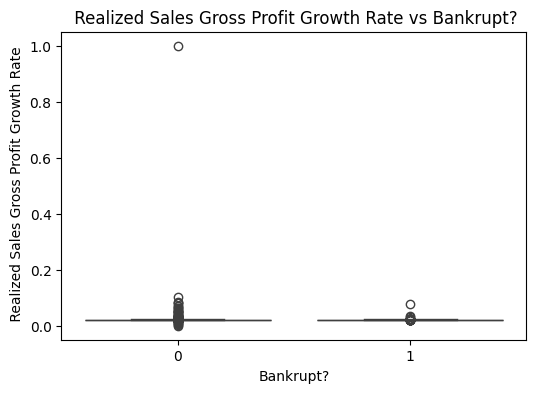

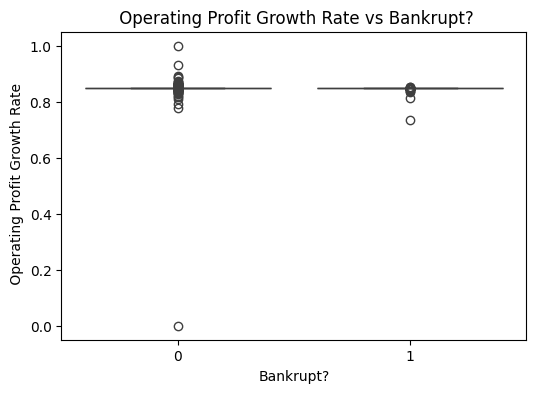

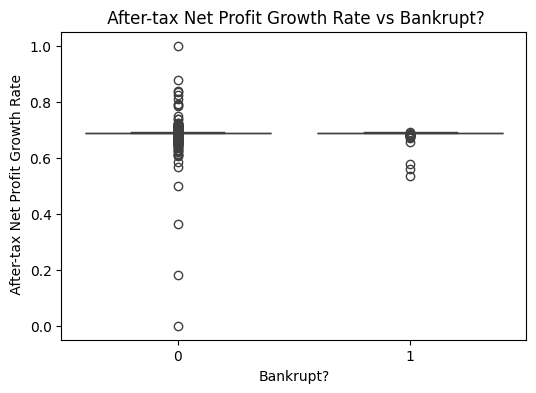

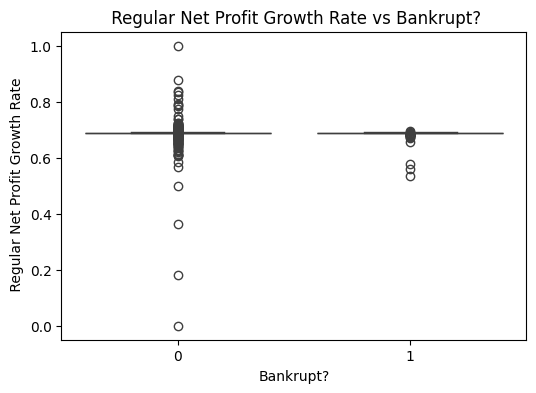

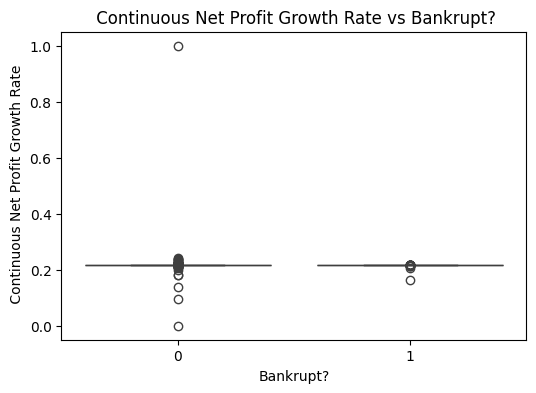

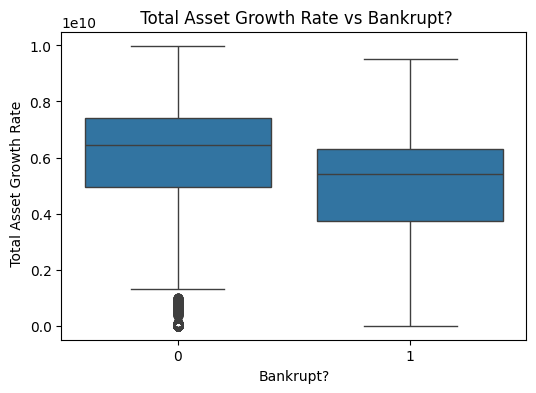

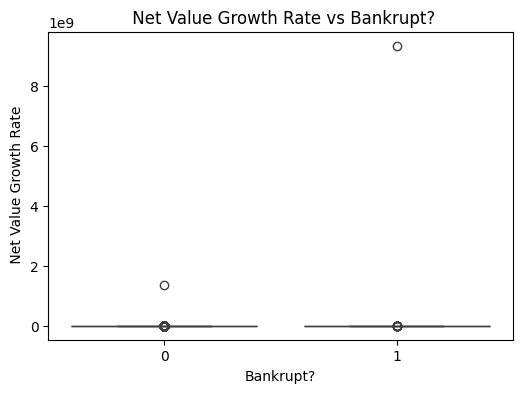

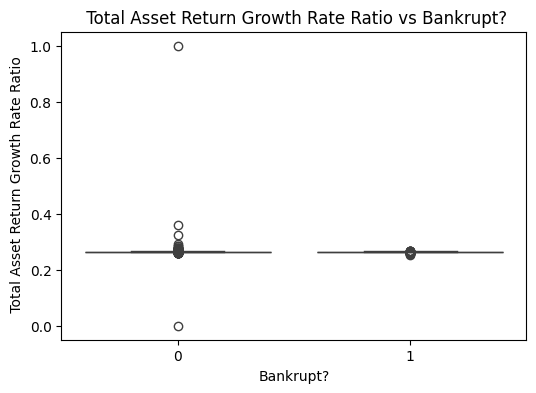

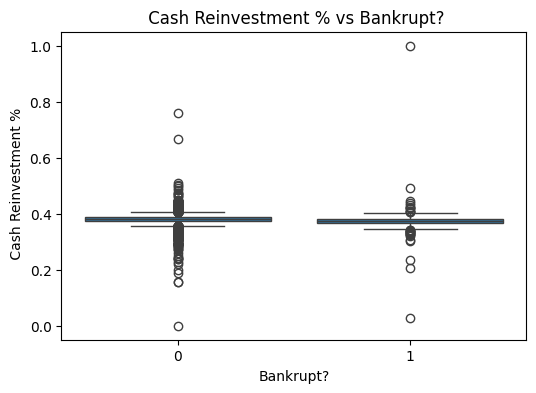

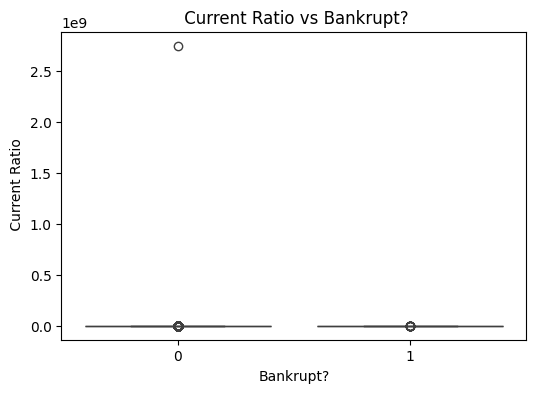

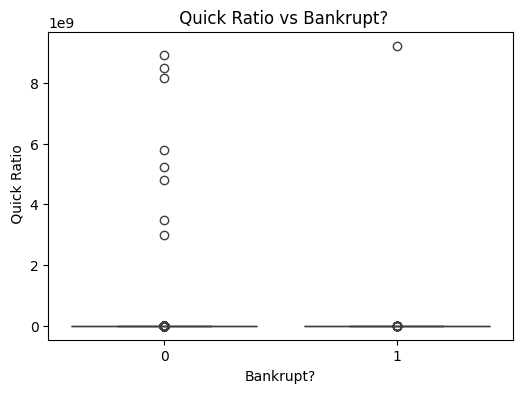

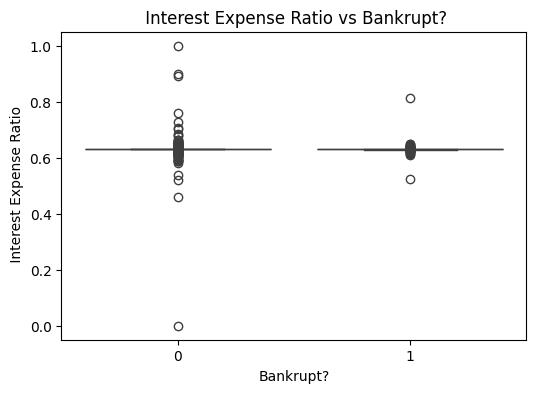

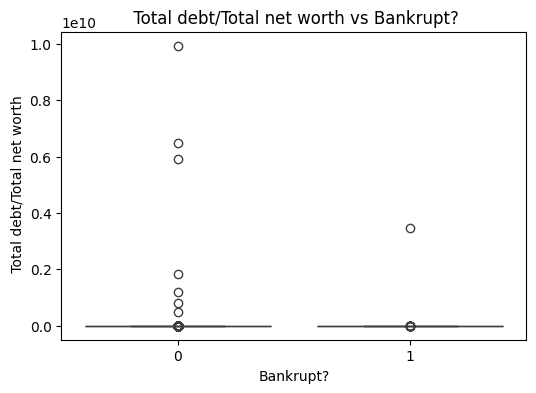

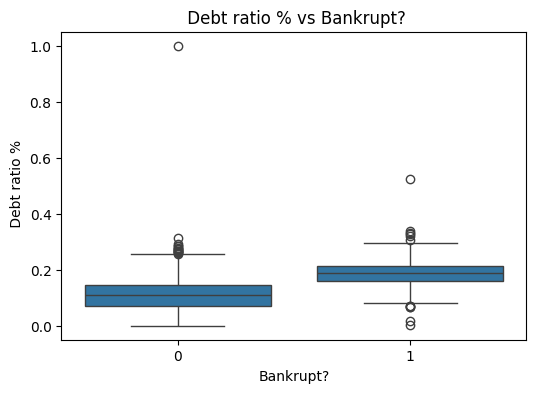

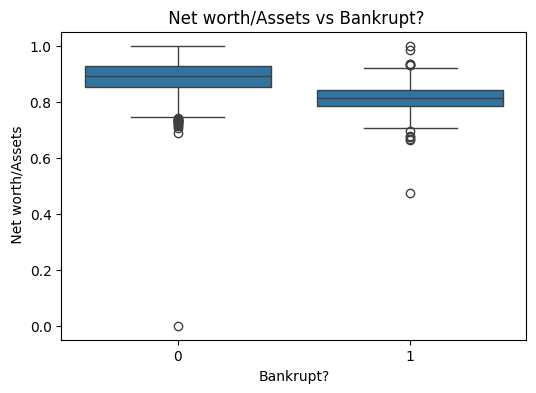

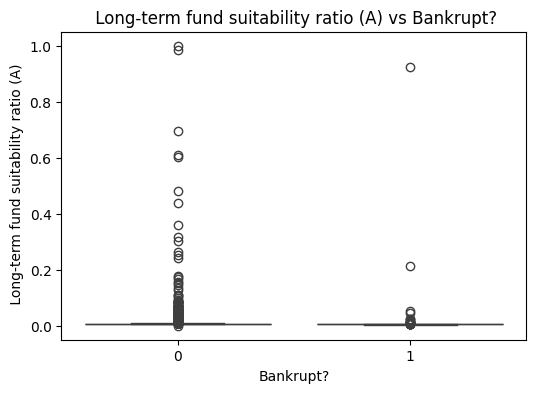

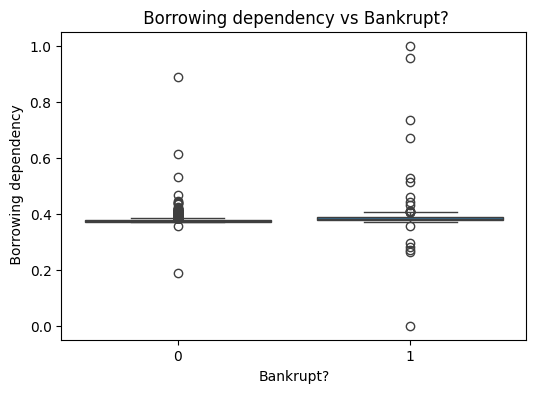

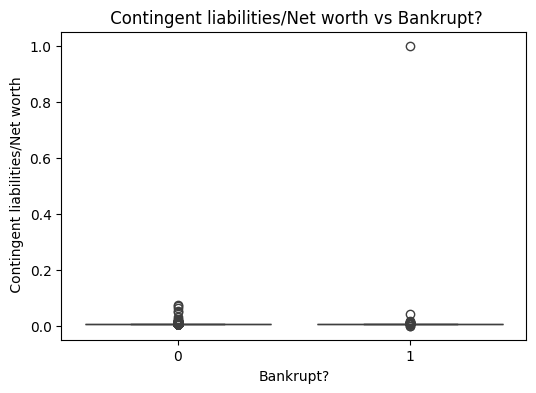

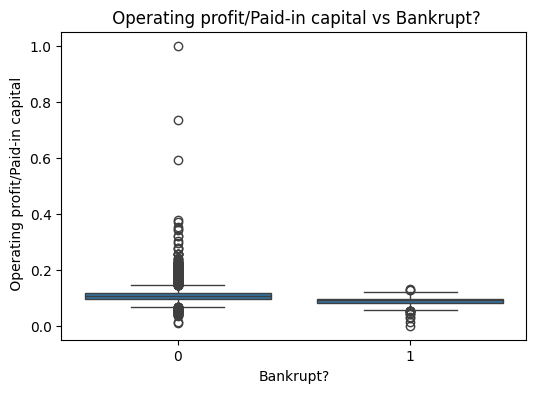

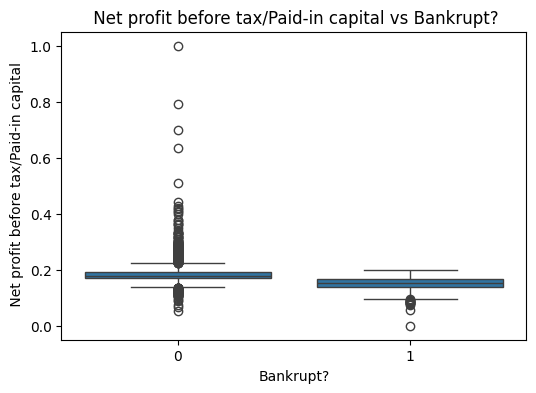

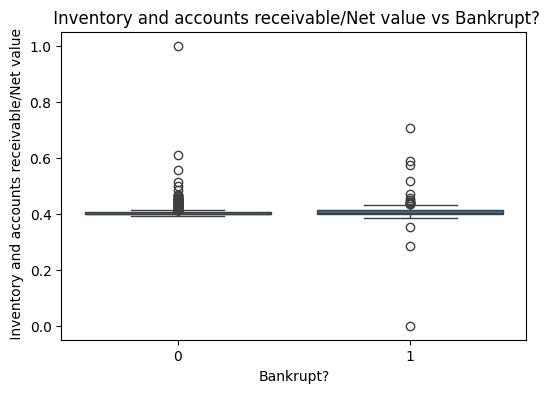

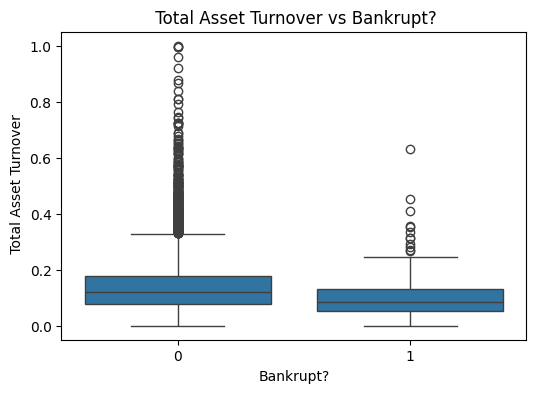

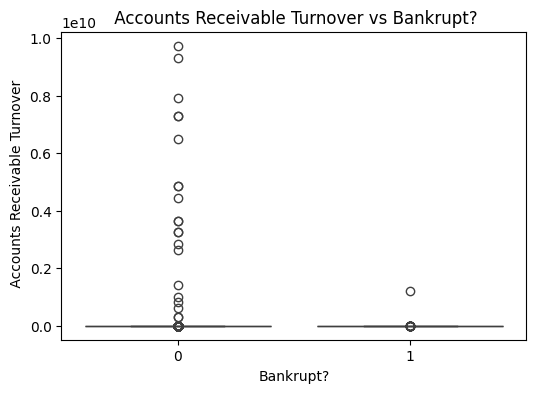

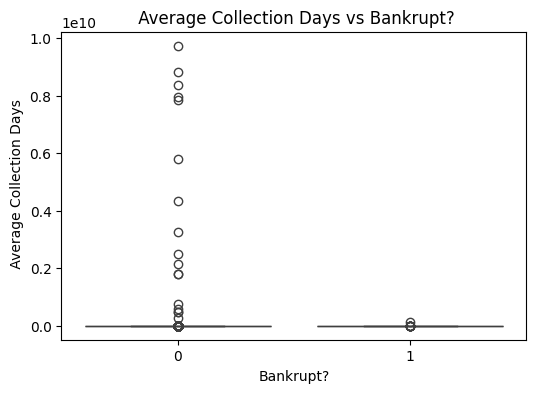

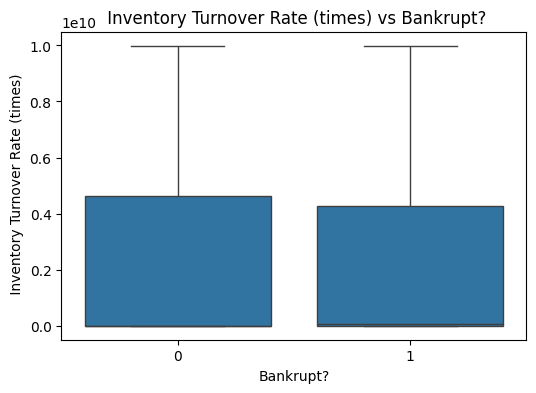

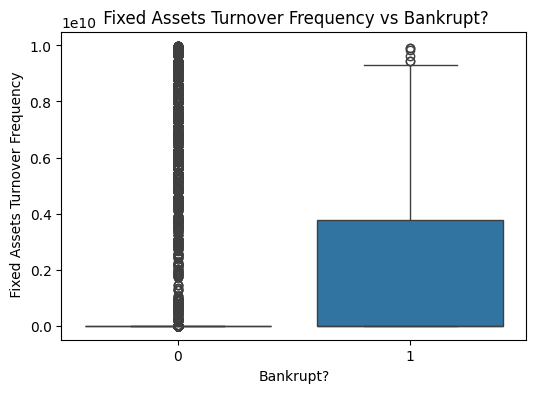

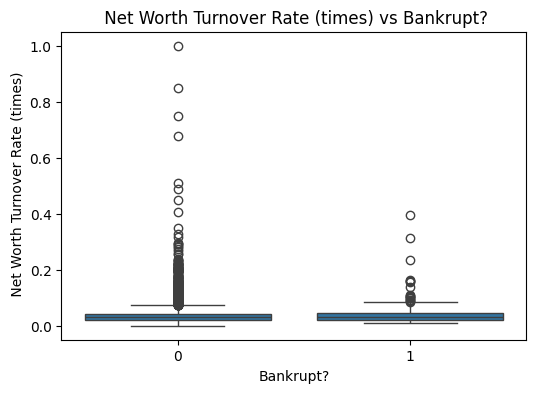

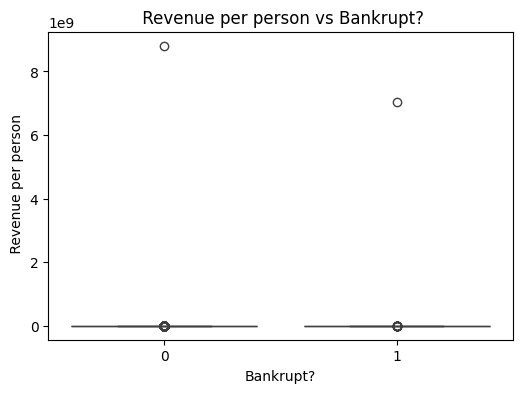

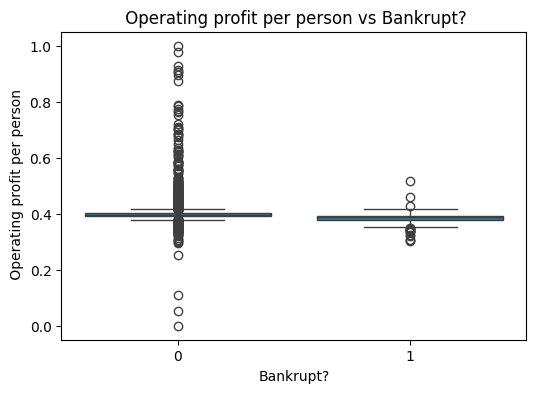

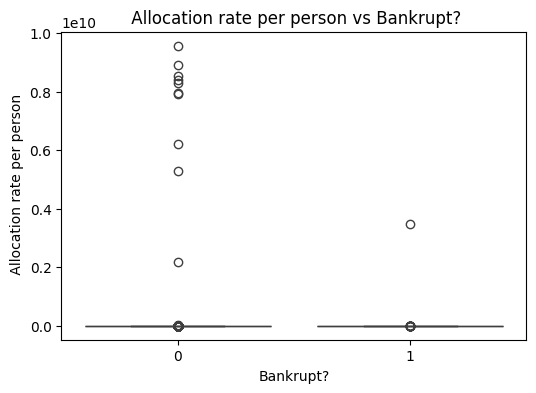

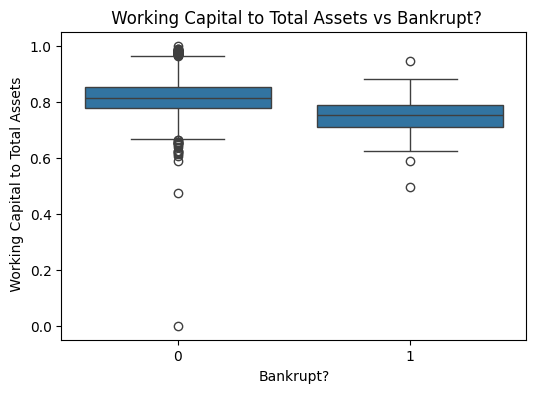

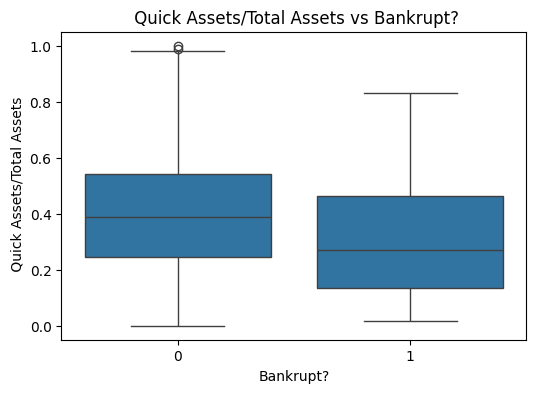

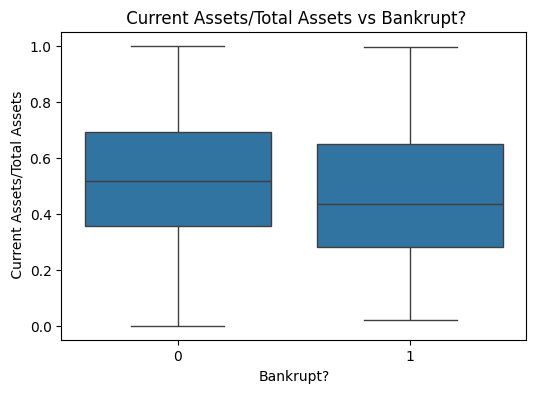

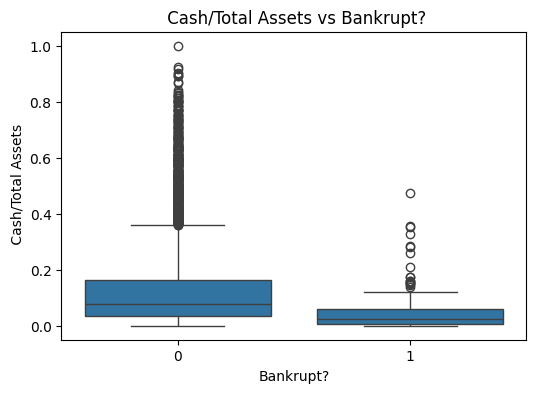

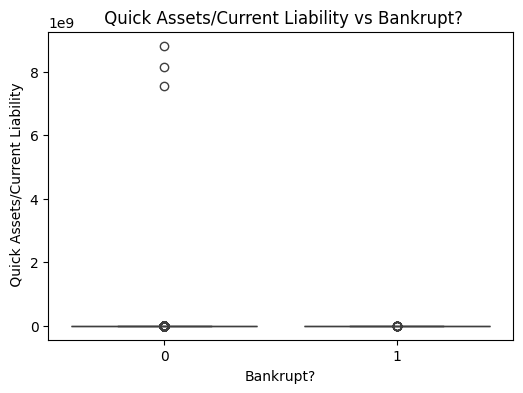

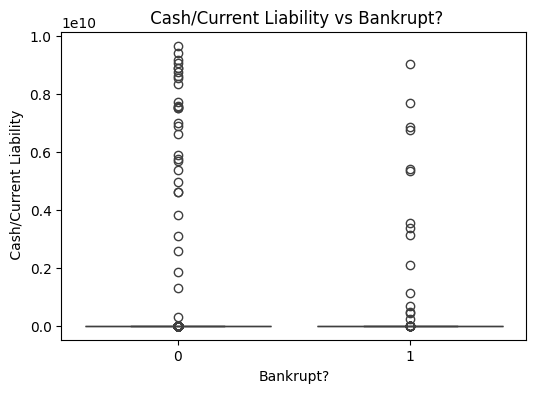

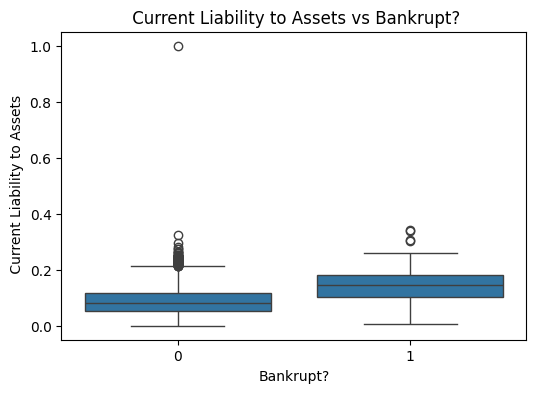

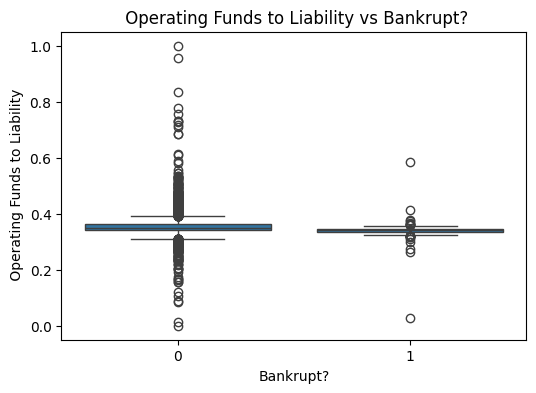

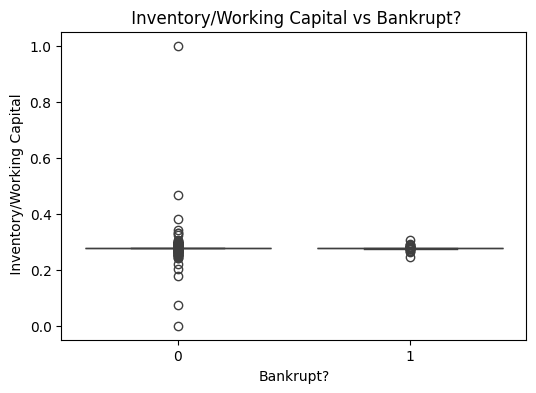

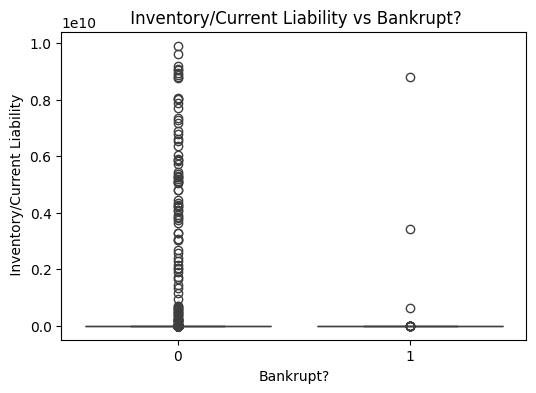

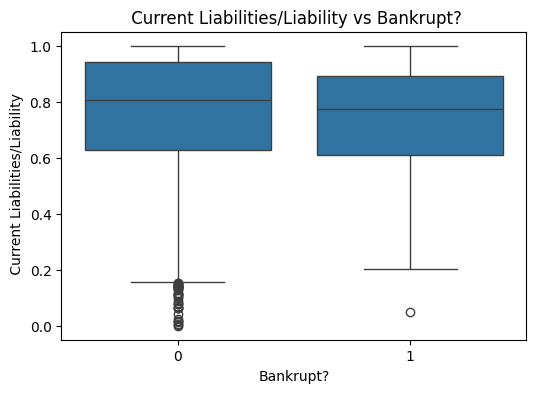

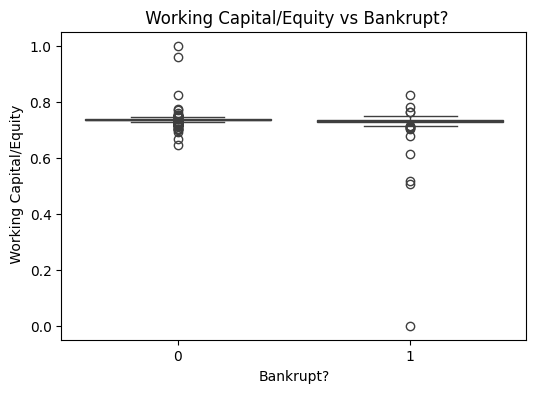

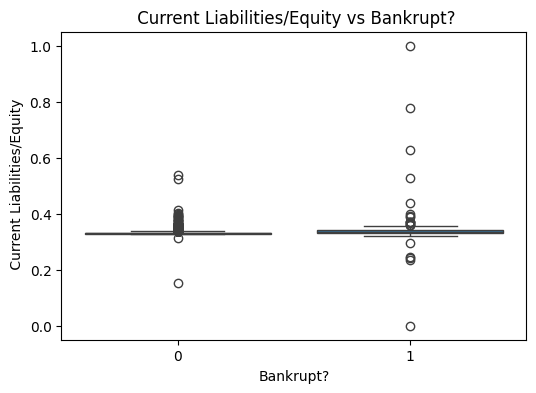

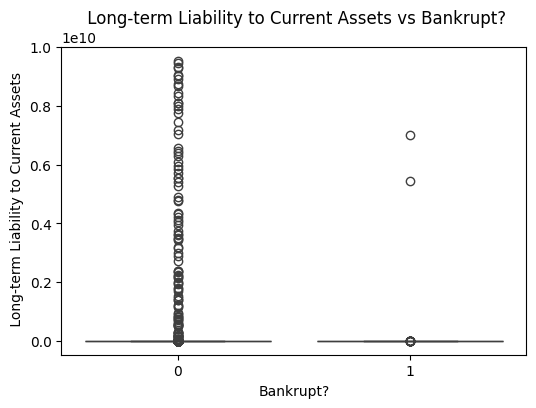

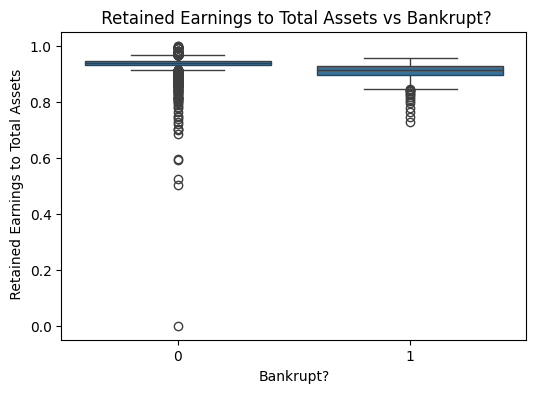

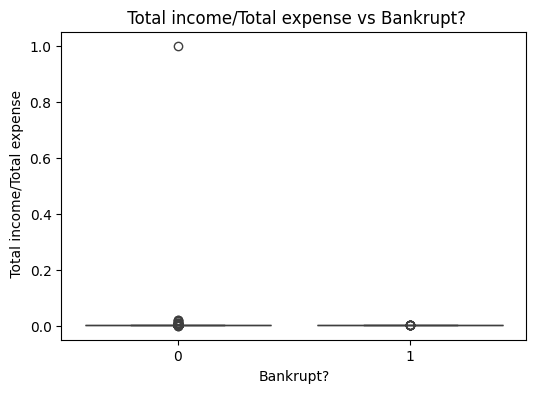

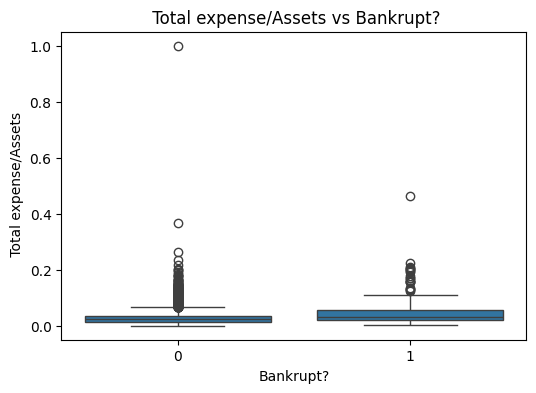

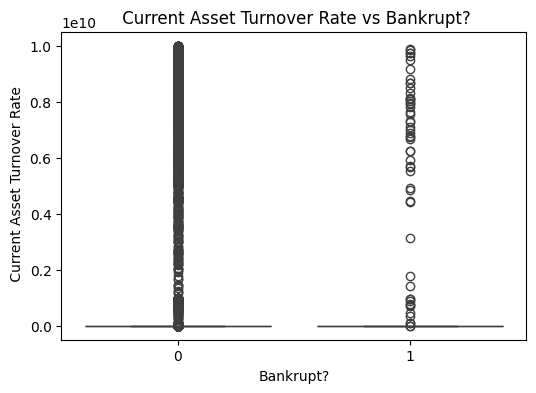

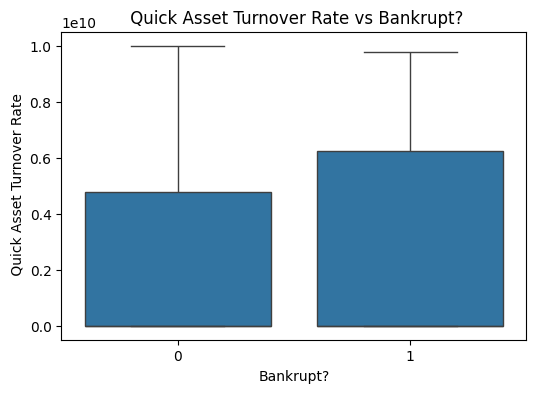

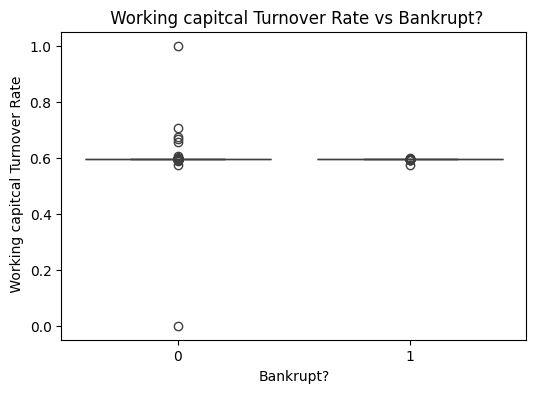

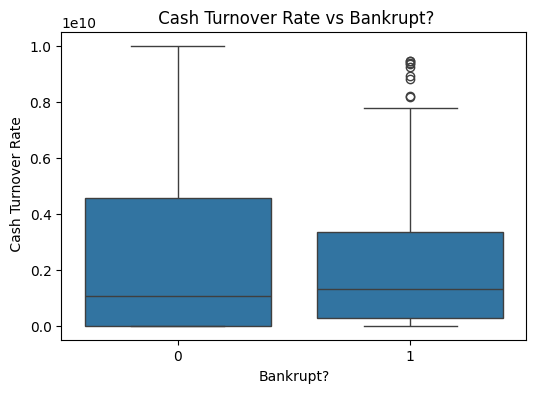

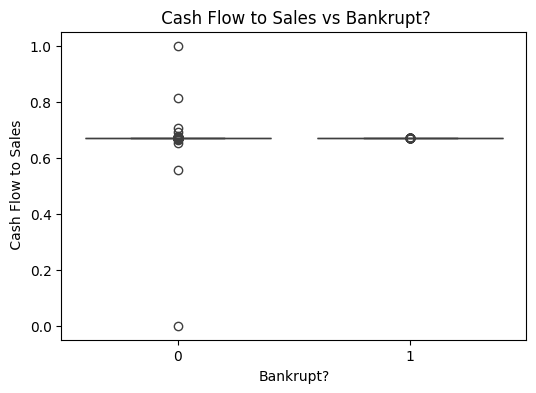

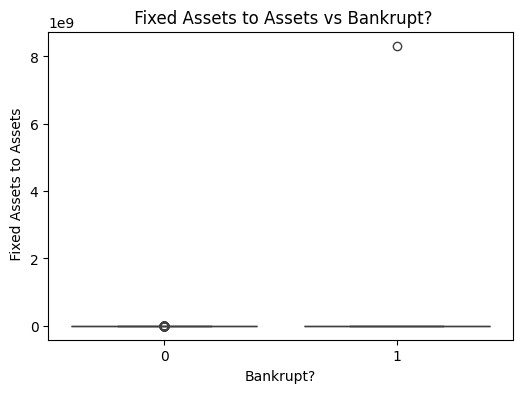

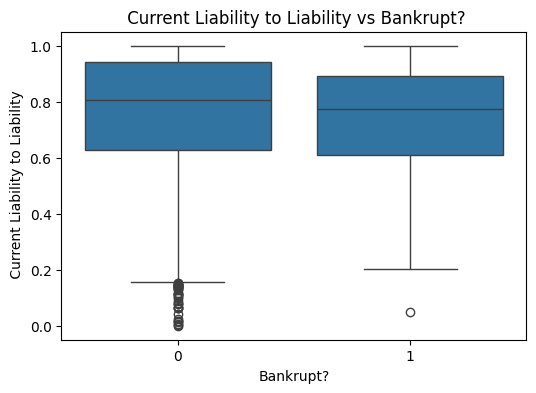

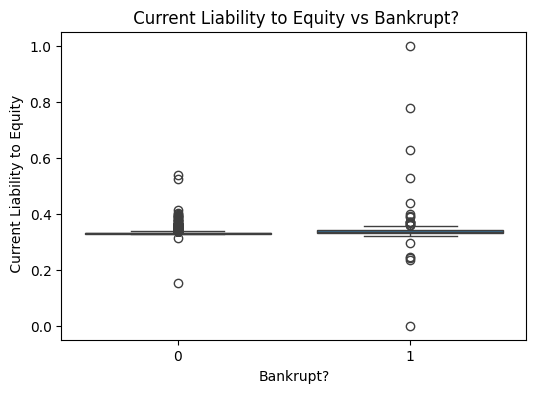

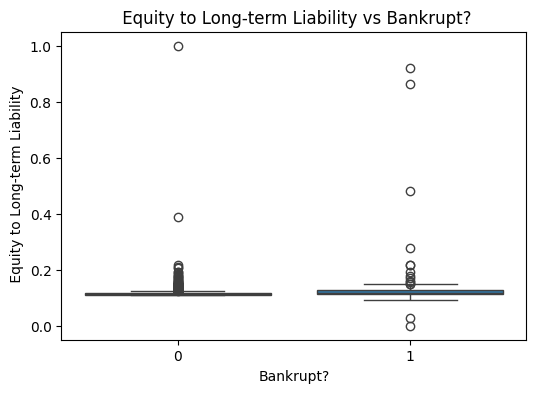

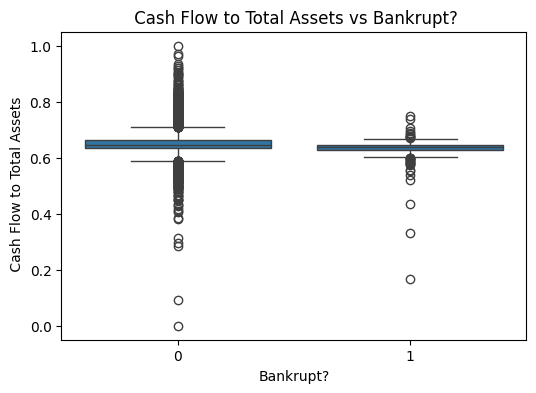

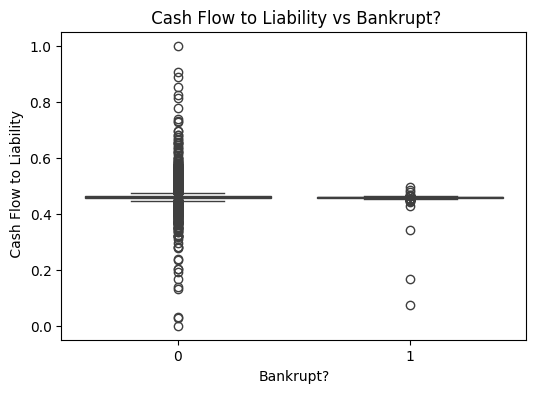

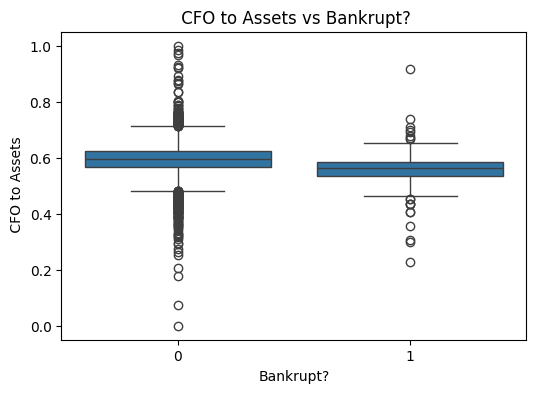

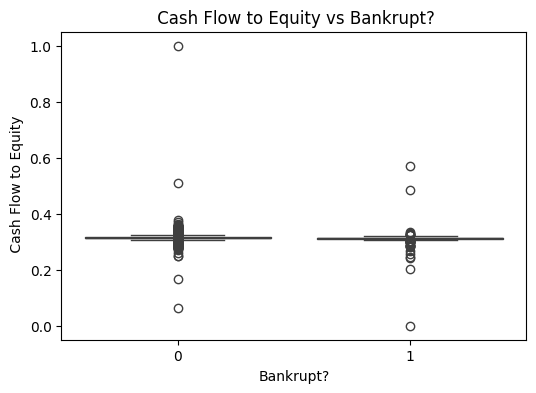

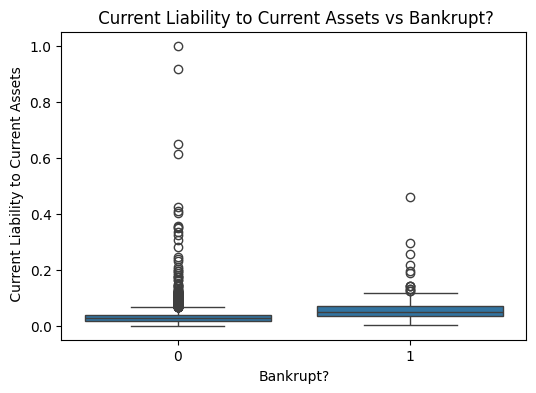

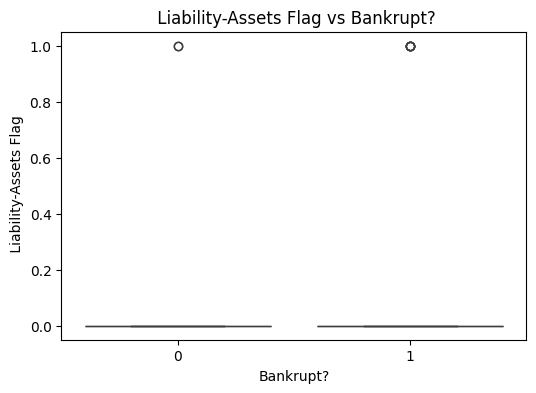

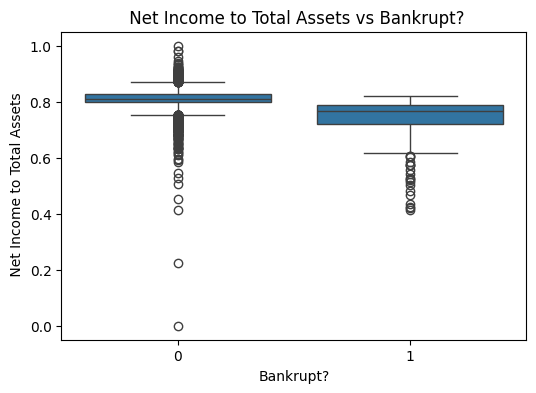

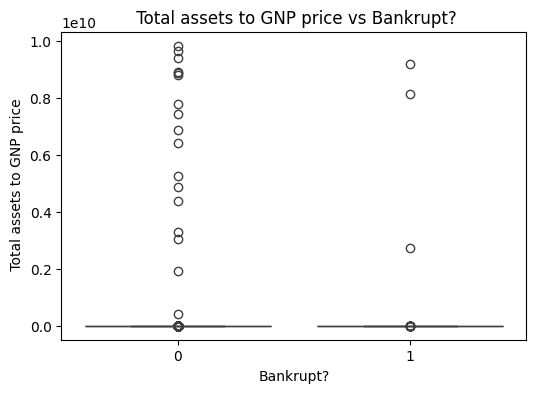

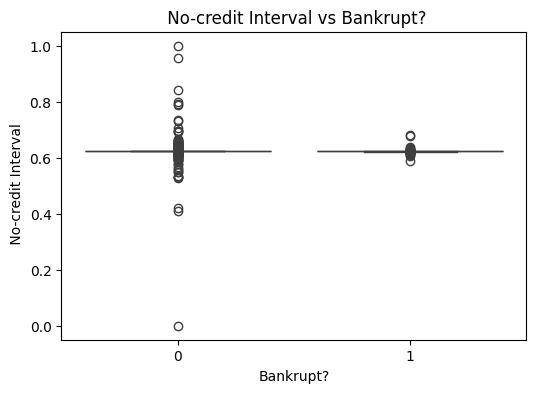

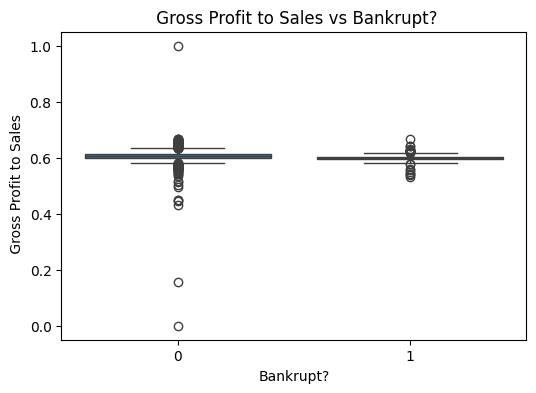

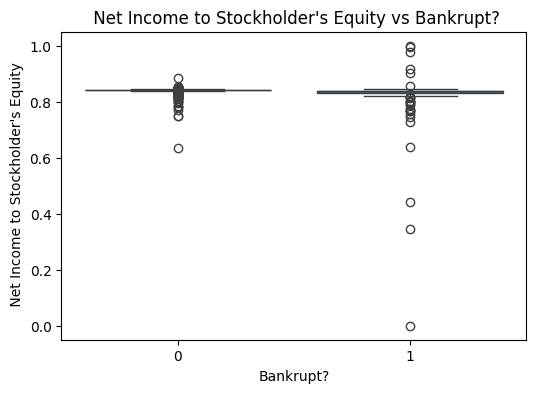

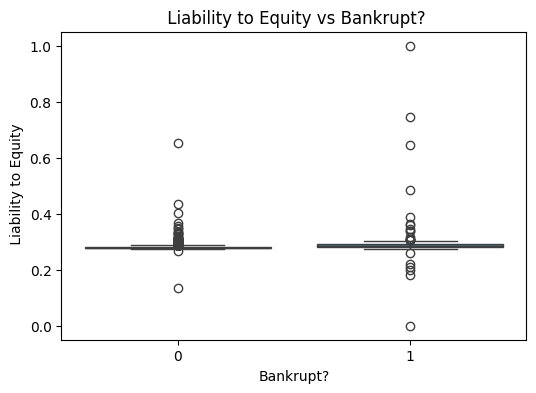

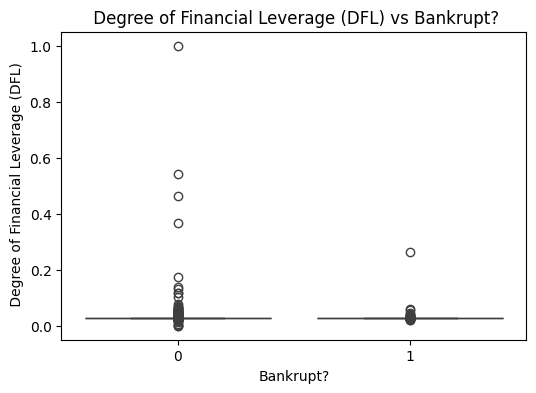

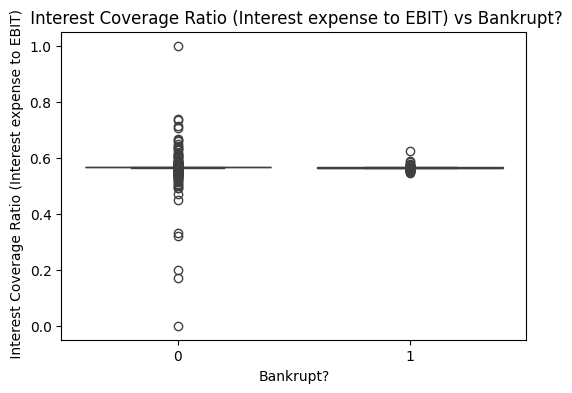

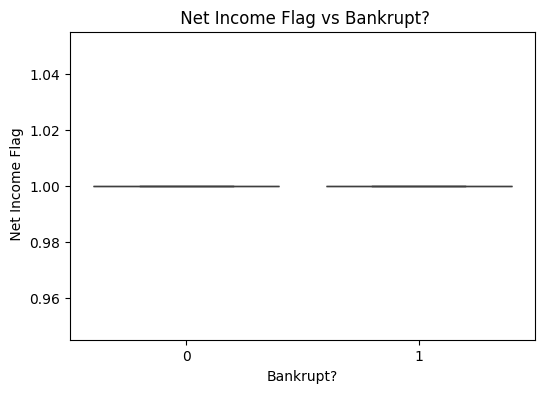

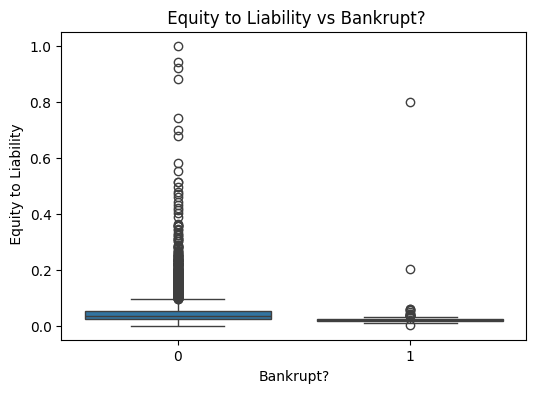

In [9]:
# Pilih hanya kolom numerik untuk analisis korelasi
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Heatmap korelasi
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

# Visualisasi boxplot terhadap target
for col in num_cols:
    if col != 'Bankrupt?':
        plt.figure(figsize=(6,4))
        sns.boxplot(x='Bankrupt?', y=col, data=df)
        plt.title(f'{col} vs Bankrupt?')
        plt.show()


#**5. Data Cleaning & Preprocessing**
Membersihkan data dari duplikat dan missing value agar model tidak error saat training.

In [10]:
# 1. Hapus duplikat
df = df.drop_duplicates().reset_index(drop=True)

# 2. Isi missing values dengan median (karena data keuangan sering skewed)
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# 3. Pastikan semua kolom numerik
df = df.apply(pd.to_numeric, errors='ignore')

print("Cek ulang missing:\n", df.isnull().sum().sum(), "data kosong tersisa")


/tmp/ipython-input-2473488824.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


Cek ulang missing:
 0 data kosong tersisa


#**6. Split Data dan Scaling**
Pisahkan fitur (X) dan target (y) lalu lakukan scaling supaya semua fitur punya skala seragam.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalisasi fitur numerik
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#**7. Tangani Imbalance Class (SMOTE)**
SMOTE menambah data minoritas (Bankrupt? = 1) agar seimbang dengan mayoritas.

In [12]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Distribusi sebelum SMOTE:", np.bincount(y_train))
print("Distribusi sesudah SMOTE:", np.bincount(y_train_res))


Distribusi sebelum SMOTE: [5279  176]
Distribusi sesudah SMOTE: [5279 5279]


#**8. Model Random Forest**
Melatih model Random Forest dan menampilkan metrik evaluasi (precision, recall, f1, ROC AUC).

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.43      0.61      0.50        44

    accuracy                           0.96      1364
   macro avg       0.71      0.79      0.74      1364
weighted avg       0.97      0.96      0.96      1364

ROC AUC: 0.9429407713498623


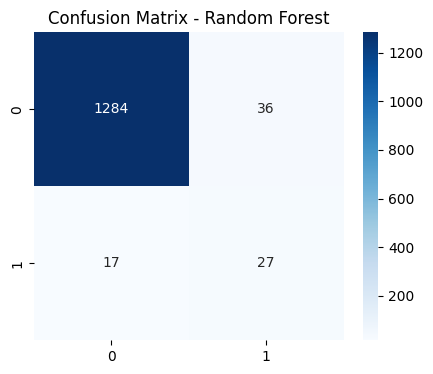

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()


#**9. Feature Importance**
Menunjukkan 10 variabel yang paling mempengaruhi prediksi kebangkrutan.

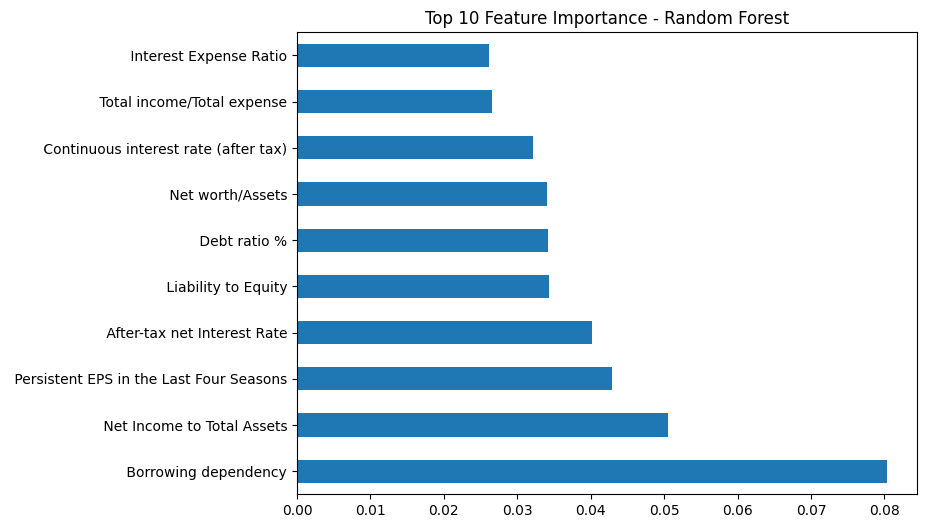

In [14]:
import pandas as pd
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importances.head(10).plot(kind='barh', figsize=(8,6))
plt.title('Top 10 Feature Importance - Random Forest')
plt.show()


#**10. Simpan Model**
Simpan model dan scaler agar bisa diunggah ke GitHub sesuai permintaan dosenmu.

In [15]:
import joblib
joblib.dump(rf, 'rf_bankrupt_model.pkl')
joblib.dump(scaler, 'scaler_bankrupt.pkl')

from google.colab import files
files.download('rf_bankrupt_model.pkl')
files.download('scaler_bankrupt.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>